In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

# Data Test 0

In [3]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data0test.txt'
data0Label = r'../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

In [4]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

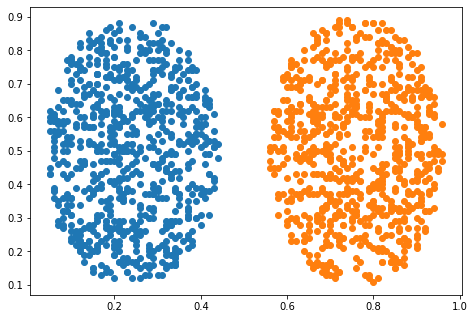

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [10]:
np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=50)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(0.5*pi*Parameter('x[0]'),0)
feature_map.rx(0.5*pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(4):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

32.98116683959961
30.443986892700195
30.369625091552734
30.170886993408203
30.170804977416992
30.170804977416992


Accuracy: 1.0


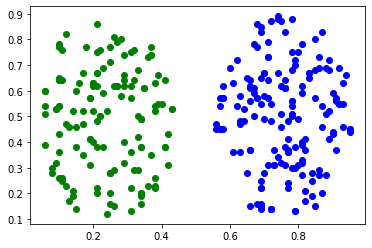

In [145]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

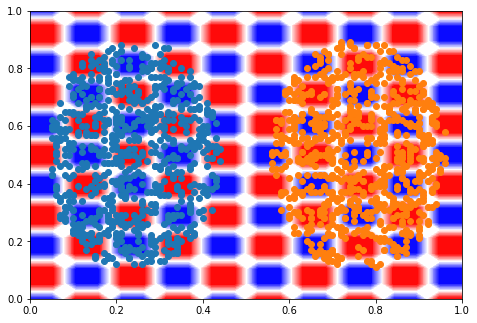

In [18]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')


X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([j,k])).detach().numpy())
        
ax.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [146]:
model2(Tensor(x))

tensor([0.4474, 0.5526], grad_fn=<_TorchNNFunctionBackward>)

Accuracy: 1.0


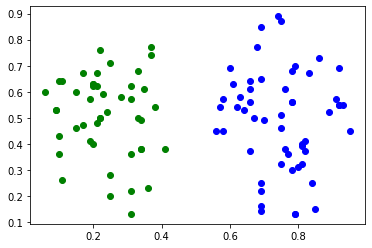

In [140]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [35]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data1b.txt'
data0Label = r'../dataset/data1blabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = ZZFeatureMap(num_inputs)

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(0.5*pi*Parameter('x[0]'),0)
feature_map.rx(0.5*pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(8):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)


    
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))



# interpret (Optional[Callable[[int], Union[int, Tuple[int, …]]]]) – 
# callable that maps the measured integer to another unsigned integer or tuple of unsigned integers. 
# these are used as new indices for the (potentially sparse) output array. 
# if this is used, the output shape of the output needs to be given as a separate argument.

list1=[0,3]
def convf(x):
    if x in list1:
        y=1;
    else:
        y=0;
    return y
convf(3)

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=convf, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);



69.05406188964844
66.59004211425781
68.72216796875
65.6316146850586
65.62060546875
65.62014770507812
65.6201400756836
65.6201400756836


Accuracy: 0.7


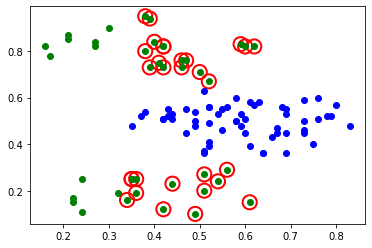

In [36]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [116]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data1b.txt'
data0Label = r'../dataset/data1blabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=50)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(8):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))



#interpret (Optional[Callable[[int], Union[int, Tuple[int, …]]]]) – 
# callable that maps the measured integer to another unsigned integer or tuple of unsigned integers. 
#hese are used as new indices for the (potentially sparse) output array. 
#f this is used, the output shape of the output needs to be given as a separate argument.

list1=[0,3]
def convf(x):
    if x in list1:
        y=1;
    else:
        y=0;
    return y
convf(3)

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=convf, output_shape=output_shape, quantum_instance=qi)


# set up PyTorch module
initial_weights = pi*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

import torch
from torch.nn import Linear, CrossEntropyLoss, MSELoss
# define model, optimizer, and loss

optimizer =LBFGS(model2.parameters())
f_loss = MSELoss(reduction='sum')


# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]))  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

26.119224548339844
27.232820510864258
26.093639373779297
26.09075164794922
26.087764739990234
26.08274269104004
26.07423973083496
26.059974670410156
26.036392211914062
25.99842071533203
25.939786911010742
25.855121612548828
25.744613647460938
25.619417190551758
26.065013885498047
27.24695587158203
25.50705337524414
26.247802734375
25.483642578125
26.103227615356445


Accuracy: 0.5


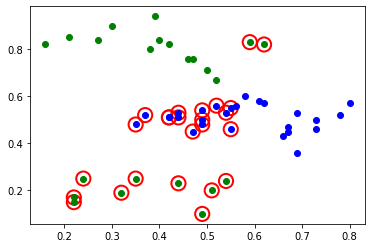

In [117]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [122]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data1c.txt'
data0Label = r'../dataset/data1clabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=50)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(pi*Parameter('x[0]'),0)
feature_map.rx(pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(8):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)
    
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))



#interpret (Optional[Callable[[int], Union[int, Tuple[int, …]]]]) – 
# callable that maps the measured integer to another unsigned integer or tuple of unsigned integers. 
#hese are used as new indices for the (potentially sparse) output array. 
#f this is used, the output shape of the output needs to be given as a separate argument.

list1=[0,3]
def convf(x):
    if x in list1:
        y=1;
    else:
        y=0;
    return y
convf(3)

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=convf, output_shape=output_shape, quantum_instance=qi)


# set up PyTorch module
initial_weights = 0.1*pi*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

import torch
from torch.nn import Linear, CrossEntropyLoss, MSELoss
# define model, optimizer, and loss

f_loss = MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)


for t in range(10000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred =  model2(Tensor(x)).reshape(1, 2) 

    # Compute and print loss.
    loss = f_loss(y_pred , Tensor([y_target]))
    if t % 50 == 49:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

49 0.5000227689743042
99 0.5000187158584595
149 0.500015377998352
199 0.5000126361846924
249 0.5000103116035461
299 0.5000084638595581
349 0.5000068545341492
399 0.5000056028366089
449 0.5000045299530029
499 0.5000036954879761
549 0.5000028610229492
599 0.5000023245811462
649 0.500001847743988
699 0.5000014305114746
749 0.500001072883606
799 0.5000008940696716
849 0.5000005960464478
899 0.500000536441803
949 0.5000003576278687
999 0.5000002980232239
1049 0.5000002384185791
1099 0.5000001192092896
1149 0.5000001192092896
1199 0.5000000596046448
1249 0.5000000596046448
1299 0.5000000596046448
1349 0.5
1399 0.5
1449 0.5
1499 0.4999999701976776
1549 0.5
1599 0.5
1649 0.5
1699 0.5
1749 0.5
1799 0.5
1849 0.4999999701976776
1899 0.4999999701976776
1949 0.5
1999 0.5
2049 0.5
2099 0.5
2149 0.5
2199 0.5
2249 0.4999999701976776
2299 0.5
2349 0.5
2399 0.4999999701976776
2449 0.4999999701976776
2499 0.5
2549 0.5
2599 0.4999999701976776
2649 0.5
2699 0.4999999701976776
2749 0.4999999701976776
2799 0

Accuracy: 0.62


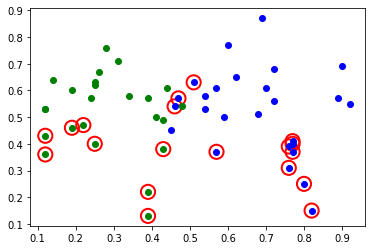

In [121]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [58]:
np.argmax()

1

In [59]:
model2(Tensor(x)).detach().numpy()

array([0.2510164, 0.7489836], dtype=float32)

In [ ]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data1b.txt'
data0Label = r'../dataset/data1blabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=2;

feature_map = ZZFeatureMap(num_inputs)

feature_map = QuantumCircuit(2, name='Embed')
feature_map.rx(0.5*pi*Parameter('x[0]'),0)
feature_map.rx(0.5*pi*Parameter('x[1]'),1)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)


param_y=[];
for i in range(8):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(2, name='PQC')
for i in range(2):
    ansatz.rx(param_y[i],i)
for i in range(2):
    ansatz.rz(param_y[i+2],i)


    
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);



# Four qubit

In [124]:
from pandas.core.common import flatten

In [125]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data0test.txt'
data0Label = r'../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(1)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

#X = [data[j][0] for j in data_ixs]
X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(8):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.rx(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)


    
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('11') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)


# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);



KeyboardInterrupt: 

Accuracy: 0.94


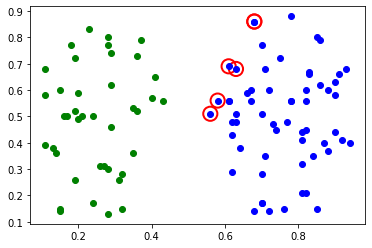

In [107]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [130]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data2a.txt'
data0Label = r'../dataset/data2alabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

np.random.seed(1)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

#X = [data[j][0] for j in data_ixs]
X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()


num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(8):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.rx(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)


    
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('11') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)


# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);



84.8124008178711
82.34944152832031
72.52180480957031
70.7346420288086
67.39808654785156
67.132568359375
67.07718658447266
67.04167938232422
67.0238265991211
67.020751953125
67.01142883300781
66.9939193725586
66.95984649658203
66.90458679199219
66.83564758300781
69.44718933105469
73.5585708618164
69.57414245605469
68.98365783691406
68.23818969726562


Accuracy: 0.49


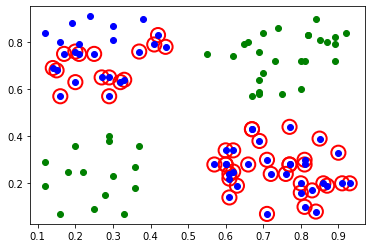

In [131]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

# Their code, just our data

In [187]:
np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

In [189]:
X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

In [39]:
model2(X_[0, :])

tensor([0.3754, 0.6246], grad_fn=<_TorchNNFunctionBackward>)

In [190]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement='linear', reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [191]:

# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

73.41181945800781
56.0578498840332
55.74957275390625
50.781959533691406
50.77006530761719
50.5999641418457
50.50127410888672
50.46675491333008
50.407752990722656
50.40599822998047
50.40486145019531
50.40122985839844
50.40011978149414
50.39993667602539
50.39993667602539


Accuracy: 0.99


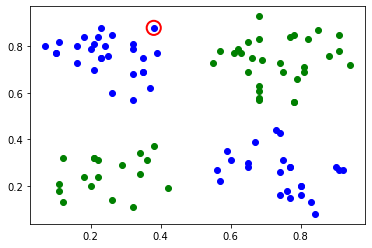

In [192]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

In [127]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data2b.txt'
data0Label = r'../dataset/data2blabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)


np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)


X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()
num_inputs=2;
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement='linear', reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);



65.99229431152344
62.504302978515625
62.19333267211914
62.056617736816406
62.03752899169922
61.76255798339844
63.89067459106445
61.601280212402344
61.4776725769043
64.74066162109375
61.20919418334961
61.11198425292969
61.06007385253906
61.051578521728516
61.04408264160156
61.04201126098633
61.0399284362793
61.0397834777832
61.039756774902344
61.039756774902344


Accuracy: 0.69


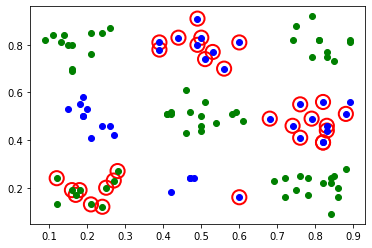

In [129]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

# easier data

In [9]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data0Path = r'../dataset/data0test.txt'
data0Label = r'../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

In [10]:
# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))
shuffled_data = shuffle(data)

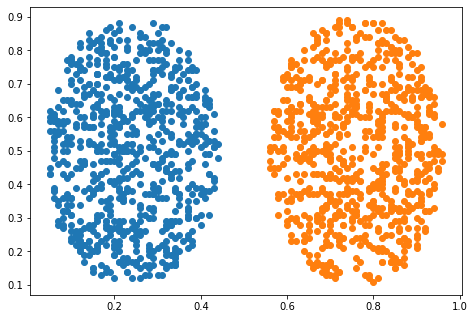

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 0)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 0)])[1::2], ls='', marker='o')

ax.plot(np.ravel(dataCoords[np.where(dataLabels == 1)])[::2],
np.ravel(dataCoords[np.where(dataLabels == 1)])[1::2], ls='', marker='o')

In [12]:
np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data), size=100)

In [13]:
X = [data[j][0] for j in data_ixs]
y = [data[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

In [22]:
num_inputs=2;
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement='linear', reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [24]:

# define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()    
def closure():
    optimizer.zero_grad(set_to_none=True)                  # initialize gradient
    
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())  # calculate loss
        
    loss.backward()                                        # backward pass
    
    print(loss.item())                                     # print loss
    return loss

# run optimizer (LBFGS requires closure)
optimizer.step(closure);

79.82890319824219
70.5885009765625
72.21388244628906
95.5162582397461
90.2008285522461
71.90900421142578
97.57010650634766
88.44446563720703
67.40546417236328
63.920780181884766
70.27200317382812
81.65528869628906
75.52881622314453
82.90984344482422
59.58333969116211
83.55851745605469
75.42849731445312
73.10794067382812
77.78231048583984
83.81229400634766


Accuracy: 0.77


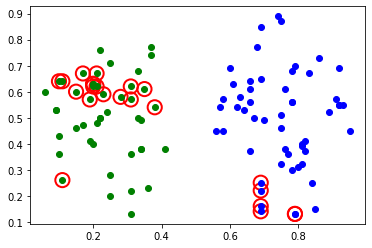

In [25]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()